In [23]:
import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
from typing import List
#from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict, TrialType
import numpy as np

In [24]:
def read_experiments(experimnt_history):
    with open(experimnt_history, 'r') as f:
        obj = yaml.safe_load(f)
    
    experiments = cattrs.structure(obj, List[Experiment])
    return experiments

In [25]:
def find_bes_trial(experiment: Experiment):
    best_trial = None
    best_val = np.inf
    for trial in experiment.trials:
        if trial.weighted_val_perplexity is not None:
            if trial.weighted_val_perplexity < best_val:
                best_val = trial.weighted_val_perplexity
                best_trial = trial
    return best_trial


In [26]:
experiment_paths = [
    "../logs/bayesian_books_cc_stack_pes2o_reddit_16init_0/experiment_history.yaml",
    "../logs/bayesian_books_cc_stack_pes2o_reddit_16init_1/experiment_history.yaml",
    "../logs/bayesian_books_cc_stack_pes2o_reddit_32init_0/experiment_history.yaml"
]

experiments = [read_experiments(path)[0] for path in experiment_paths]
best_trials = [find_bes_trial(experiment) for experiment in experiments]
for i, trial in enumerate(best_trials):
    print(f"Experiment {i} has best weighted val perplexity of {trial.weighted_val_perplexity}. Mixing weights: {trial.true_mixing_weights}")
rel_trials = [ [trial for trial in experiment.trials if trial.weighted_val_perplexity is not None] for experiment in experiments]
rel_trials = [trial for sublist in rel_trials for trial in sublist]

Experiment 0 has best weighted val perplexity of 4.39272717833519. Mixing weights: {'Books': 0.05773401803184556, 'CC': 0.21766119397704792, 'Pes2O': 0.22361556736633276, 'Reddit': 0.15008395448768713, 'stack-v4': 0.35090526613708667}
Experiment 1 has best weighted val perplexity of 4.382295963168144. Mixing weights: {'Books': 0.15927633333514757, 'CC': 0.09910684642221508, 'Pes2O': 0.2177204717766735, 'Reddit': 0.20066836842993288, 'stack-v4': 0.3232279800360309}
Experiment 2 has best weighted val perplexity of 4.368822938203812. Mixing weights: {'Books': 0.15785849965438603, 'CC': 0.20688125574889377, 'Pes2O': 0.27057763795984346, 'Reddit': 0.10846291589334407, 'stack-v4': 0.2562196907435327}


In [27]:
values = np.array([trial.weighted_val_perplexity for trial in rel_trials])
weights = np.array([list(trial.true_mixing_weights.values()) for trial in rel_trials])

# Create weight clusters
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Create a combined feature matrix by concatenating values and weights
feature_matrix = np.column_stack((weights, values))
feature_matrix = weights

# Perform hierarchical clustering using the 'ward' method
linked = linkage(feature_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Trials')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Determine clusters by cutting the dendrogram at a specific threshold
# Adjust the threshold based on your dendrogram plot
threshold = 0.1  # Example threshold
clusters = fcluster(linked, threshold, criterion='distance')

# clusters now contains the cluster labels for each trial
print(clusters)

[15 25 27 21 22 24 46 31 30 16  6 12  7 45 46 26 36 35 28 48 23 49 42 47
  1 29 43 13 49 30 48 48  6 45 31 22 24 16 16 11 25 11 18 33 15 21  8 32
 37 28  4 44 30 36 47 12 30 42  2 44 46 35 46 19 43 13  9 43 41 49 40 49
 20 49 41 40 39 12 41 39 18  8 18 29 22 11 24 26 46 45 11  9 32 27 37 16
 16 46  7 14 21 15 12  6 30 25 39 22 45 25 31 33  9 44 34 49 43 46 48 28
 48 49 48 36  4 38 10 39 17 18  6 41 46 48  5 42 19 49 49  9 28 40  3 41
 43]


In [ ]:
#assign trials to clusters
clusters_dict = {}
for i, cluster in enumerate(clusters):
    if cluster not in clusters_dict:
        clusters_dict[cluster] = {
            "trials": []
        }
    clusters_dict[cluster]["trials"].append(rel_trials[i])


for cluster, cluster_dict in clusters_dict.items():
    perplexities = [trial.weighted_val_perplexity for trial in cluster_dict["trials"]]
    best_perplexity = min(perplexities)
    best_weights = list(cluster_dict["trials"][np.argmin(perplexities)].true_mixing_weights.values())
    mean_perplexity = np.mean(perplexities)
    std = np.std(perplexities)
    print(f"Cluster {cluster} has {len(cluster_dict['trials'])} trials. Best perplexity: {best_perplexity}, mean perplexity: {mean_perplexity}, std: {std}")
    
    clusters_dict[cluster]["best_perplexity"] = best_perplexity
    clusters_dict[cluster]["best_weights"] = best_weights
    clusters_dict[cluster]["mean_perplexity"] = mean_perplexity
    clusters_dict[cluster]["std"] = std

# reorder clusters dict by best perplexity
clusters_dict = {k: v for k, v in sorted(clusters_dict.items(), key=lambda item: item[1]["best_perplexity"])}

Cluster 15 has 3 trials. Best perplexity: 4.667310339212418, mean perplexity: 4.667310339212418, std: 0.0
Cluster 25 has 4 trials. Best perplexity: 4.547214865684509, mean perplexity: 4.5705574825406075, std: 0.040430598376375734
Cluster 27 has 2 trials. Best perplexity: 4.585555350780488, mean perplexity: 4.585555350780488, std: 0.0
Cluster 21 has 3 trials. Best perplexity: 4.5974379807710655, mean perplexity: 4.5974379807710655, std: 0.0
Cluster 22 has 4 trials. Best perplexity: 4.508045932650566, mean perplexity: 4.509276707470416, std: 0.0021317645206583823
Cluster 24 has 3 trials. Best perplexity: 4.4810533106327055, mean perplexity: 4.4810533106327055, std: 0.0
Cluster 46 has 8 trials. Best perplexity: 4.41090335547924, mean perplexity: 4.436081607639791, std: 0.024617164536788468
Cluster 31 has 3 trials. Best perplexity: 4.570376259088516, mean perplexity: 4.570376259088516, std: 0.0
Cluster 30 has 5 trials. Best perplexity: 4.502324020862579, mean perplexity: 4.553503123521804,

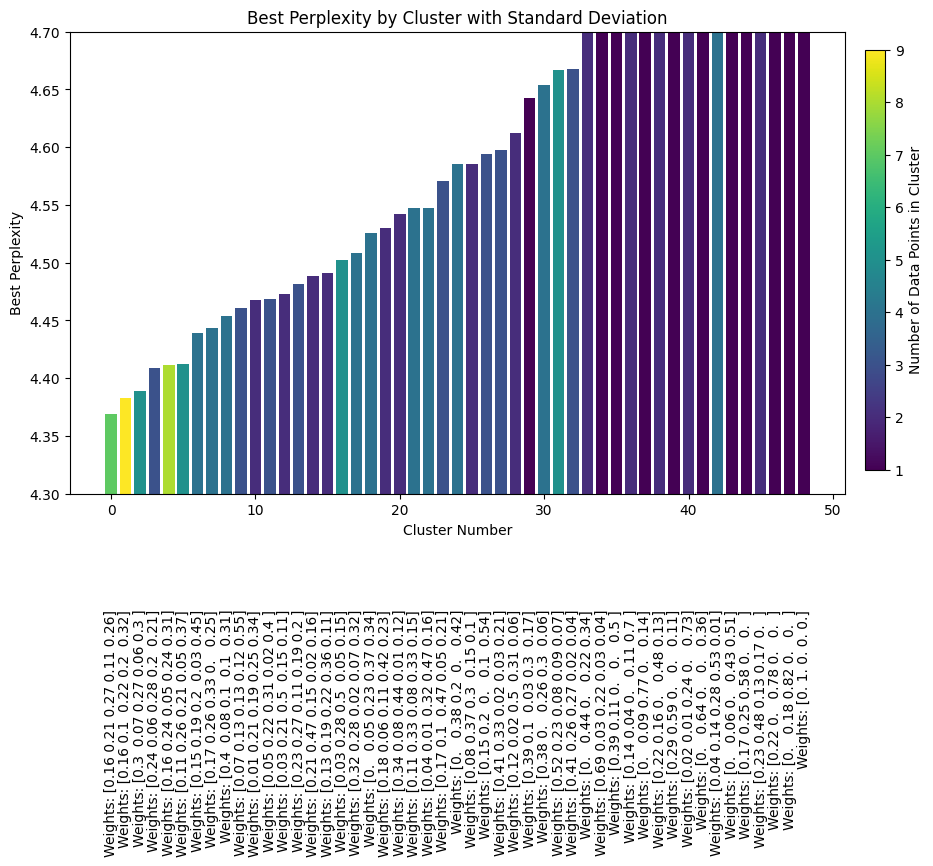

In [ ]:
# Assuming clusters_dict is already defined
# Extract the relevant information from the clusters_dict
best_perplexities = [cluster["best_perplexity"] for cluster in clusters_dict.values()]
std_devs = [cluster["std"] for cluster in clusters_dict.values()]
mixing_weights = [cluster["best_weights"] for cluster in clusters_dict.values()]
num_data_points = [len(cluster["trials"]) for cluster in clusters_dict.values()]

# Normalize the number of data points for coloring
norm = plt.Normalize(vmin=min(num_data_points), vmax=max(num_data_points))
cmap = plt.cm.viridis

# Create the figure and the axes, reserving space for the color bar
fig, ax = plt.subplots(figsize=(10, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height] for colorbar

# Create a bar plot with error bars and color based on the number of data points
bars = ax.bar(
    range(len(best_perplexities)), 
    best_perplexities, 
    #yerr=std_devs, 
    capsize=5, 
    color=cmap(norm(num_data_points))
)

ax.set_xlabel('Cluster Number')
ax.set_ylabel('Best Perplexity')
ax.set_title('Best Perplexity by Cluster with Standard Deviation')
ax.set_ylim(4.3, 4.7)

# Add mixing weights as rotated labels below each bar
for bar, weights in zip(bars, mixing_weights):
    ax.text(bar.get_x() + bar.get_width() / 2.0, bar.get_y() + 4.2, 
            f"Weights: {np.round(weights, 2)}", ha='center', va='top', rotation=90)

# Add the color bar to the explicit axis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only for the colorbar; no need to pass actual data
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Number of Data Points in Cluster')

plt.show()


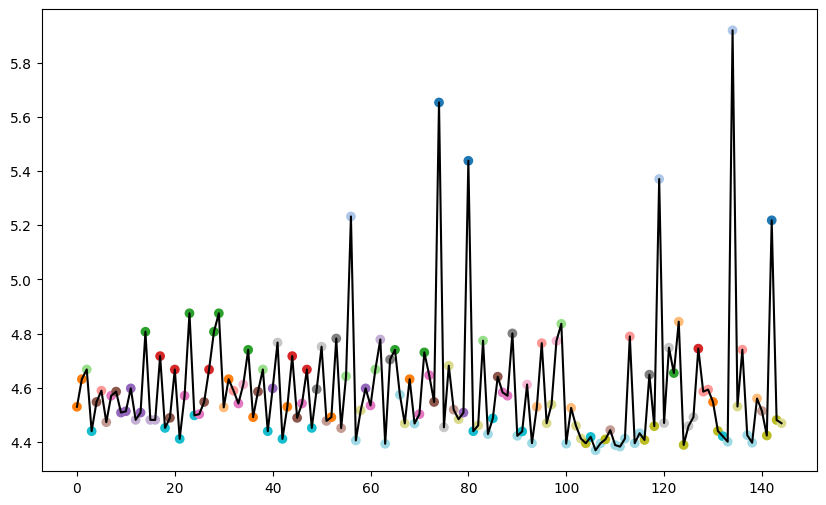

In [ ]:
# plot perplexity over trials, color by cluster
import matplotlib
no_clusters = len(clusters_dict)
cluster_colors = matplotlib.colormaps.get_cmap('tab20')(np.linspace(0, 1, no_clusters))


values = []
for cluster, cluster_dict in clusters_dict.items():
    cluster_color = cluster_colors[cluster-1]
    local_array = []
    for trial in cluster_dict["trials"]:
        local_array.append((trial.weighted_val_perplexity, cluster_color, trial.idx))
    values.extend(local_array)

values = sorted(values, key=lambda x: x[2])

plt.figure(figsize=(10, 6))
y_values = [x[0] for x in values]
colors = [x[1] for x in values]
plt.plot(y_values, color='black')
plt.scatter(range(len(y_values)), y_values, c=colors)
